# Low Temperature Cooling System

*The LT cooling loop is for anything in the engine room that gives off to much heat. Unlike the engine, the components that the LT line cools don't have to stay warm to operate. They simply need to have the excess heat they produce removed.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Params

* Low Temperature Cooling System
 * LT Cooling System Temperature
   * 05LT
     * Before chare air cooler
     * OUTLET H.T COOLING WATER TEMP
 * HT Cooling System Pressure
   * 10LT
     * Water Pressure
     * INLET H.T COOLING WATER TEMP
     * Pressure is lower than temperature
* Charge Air
 * Temperature
   * 05CA
     * ENGINE AIR COOLER OUTL CHARGE AIT TEMP
* Starting Air
 * Pressure
   * 10SA
     * Starting air pressure
   * 14SA
     * Starting air pressure
* Lube Oil Filter
 * Lube Oil Filter Pressure
   * Before Filter
     * 13LO
   * After Filter
     * 14LO
  

      

In [20]:
import os
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import drive.MyDrive.scripts.utils as util

from datetime import datetime
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

warnings.filterwarnings('ignore')

# Preprocessing the Data and Analysing correlation attributes

In [21]:
''' DATASET
-------------------------------------------------------
'''

# Dataset size
SIZE = 'month' # Alternative: 'day'

# Median filter window size
window_size = 355

# Insert preferred ship and date here
FILE = {
    'start': 'drive/MyDrive/dataset/',
    'ship': '13218',
    'year': '2023',
    'month': '3',
    'day': '4'
}

if (SIZE == 'month'):
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}'
else:
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}-{FILE["day"]}'


# NB: Changing this will alter what attributes the model will be trained to predict
y_attr = ['10LT']

# NB: Changing this will alter what attributes the model will receive as input
x_attr = ['05LT', '05CA', '13LO', '10LO']


# Prediction tag name
TAG_NAME = 'LT'




''' MODEL
-------------------------------------------------------
'''



# Path to model directory
DIR = f'/content/drive/MyDrive/models/{TAG_NAME}/'





''' OTHER
-------------------------------------------------------
'''

# Getting current date
DATE = datetime.today().strftime('%Y-%m-%d')

# Decimal place to round
ROUND = 3

# Apply attribute filtering
FILTERING = True

In [22]:
if SIZE == 'month':
  try:
    df = util.open_dataset_at_month(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_month(FILE)
else:
  try:
    df = util.open_dataset_at_date(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_date(FILE)
df

,B21CA,14LO,24EL,07HT,54XA,55XA,57XA,16DO,15LO,05XS,...,05EX,01EX,06LO,06EX,07EX,08EX,05HT,87XS,missingMsgCount,frequencyMsgCount
time,,,,,,,,,,,,,,,,,,,,,
2023-03-01 11:40:11,0.531,4.612,11.640,78.8,5.0,5.0,5.0,7.352,4.633,False,...,328.0,328.0,68.1,343.0,330.0,319.0,76.8,NaN,NaN,NaN
2023-03-01 11:40:12,0.524,4.578,11.128,78.8,5.0,5.0,5.0,7.526,4.604,False,...,328.0,328.0,68.1,343.0,330.0,319.0,76.8,NaN,NaN,NaN
2023-03-01 11:40:13,0.524,4.586,10.848,78.8,5.0,5.0,5.0,7.150,4.575,False,...,328.0,328.0,68.1,343.0,330.0,319.0,76.8,NaN,NaN,NaN
2023-03-01 11:40:14,0.519,4.606,10.760,78.8,5.0,5.0,5.0,6.962,4.618,False,...,328.0,328.0,68.1,343.0,330.0,319.0,76.8,NaN,NaN,NaN
2023-03-01 11:40:15,0.507,4.627,10.912,78.9,5.0,5.0,5.0,7.341,4.712,False,...,328.0,328.0,68.1,343.0,330.0,319.0,76.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 23:59:55,-0.016,0.000,-1.240,35.1,5.0,5.0,5.0,0.162,-0.041,False,...,39.0,39.0,31.6,39.0,38.0,38.0,31.9,0.0,NaN,NaN
2023-03-31 23:59:56,-0.016,0.000,-1.240,35.1,5.0,5.0,5.0,0.159,-0.041,False,...,39.0,39.0,31.6,39.0,38.0,38.0,31.9,0.0,NaN,NaN
2023-03-31 23:59:57,-0.016,0.000,-1.240,35.1,5.0,5.0,5.0,0.162,-0.041,False,...,39.0,39.0,31.6,39.0,38.0,38.0,31.9,0.0,NaN,NaN


In [23]:
# This code was generated by ChatGPT (OpenAI)
df.fillna(df.mean(), inplace=True)

In [24]:
df, x_attr, y_attr, controlled_parameters = util.produce_modified_dataset(df, x_attr, y_attr)
df

,05CA,05LT,10LO,13LO,10LT
time,,,,,
2023-03-01 11:40:11,40.7,33.2,4.7,5.4,5.2
2023-03-01 11:40:12,40.7,33.2,4.7,5.4,5.2
2023-03-01 11:40:13,40.7,33.1,4.7,5.4,5.2
2023-03-01 11:40:14,40.7,33.1,4.7,5.4,5.2
2023-03-01 11:40:15,40.5,33.1,4.7,5.4,5.2
...,...,...,...,...,...
2023-03-31 23:59:55,32.0,32.3,0.0,-0.1,0.6
2023-03-31 23:59:56,32.0,32.3,0.0,-0.1,0.6
2023-03-31 23:59:57,32.0,32.3,0.0,-0.1,0.6


In [25]:
# Returns the first n rows for the objects
df.head()

,05CA,05LT,10LO,13LO,10LT
time,,,,,
2023-03-01 11:40:11,40.7,33.2,4.7,5.4,5.2
2023-03-01 11:40:12,40.7,33.2,4.7,5.4,5.2
2023-03-01 11:40:13,40.7,33.1,4.7,5.4,5.2
2023-03-01 11:40:14,40.7,33.1,4.7,5.4,5.2
2023-03-01 11:40:15,40.5,33.1,4.7,5.4,5.2


In [26]:
# Prints information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2624252 entries, 2023-03-01 11:40:11 to 2023-03-31 23:59:59
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   05CA    float64
 1   05LT    float64
 2   10LO    float64
 3   13LO    float64
 4   10LT    float64
dtypes: float64(5)
memory usage: 120.1 MB


In [27]:
df.shape

(2624252, 5)

In [28]:
# Returns the description of the data in the Data Frame
df.describe()

,05CA,05LT,10LO,13LO,10LT
count,2.624252e+06,2.624252e+06,2.624252e+06,2.624252e+06,2.624252e+06
mean,4.177080e+01,3.468710e+01,3.918557e+00,4.685579e+00,4.384517e+00
std,4.640535e+00,5.722952e+00,1.743931e+00,2.133789e+00,1.701580e+00
min,2.200000e+01,2.120000e+01,0.000000e+00,-1.000000e-01,2.000000e-01
25%,3.880000e+01,2.990000e+01,4.700000e+00,5.500000e+00,5.100000e+00
50%,4.170000e+01,3.420000e+01,4.700000e+00,5.500000e+00,5.200000e+00
75%,4.340000e+01,3.580000e+01,4.700000e+00,5.800000e+00,5.200000e+00
max,5.780000e+01,5.770000e+01,6.100000e+00,8.600000e+00,5.600000e+00


In [29]:
df.columns

Index(['05CA', '05LT', '10LO', '13LO', '10LT'], dtype='object')

# Data Analysing

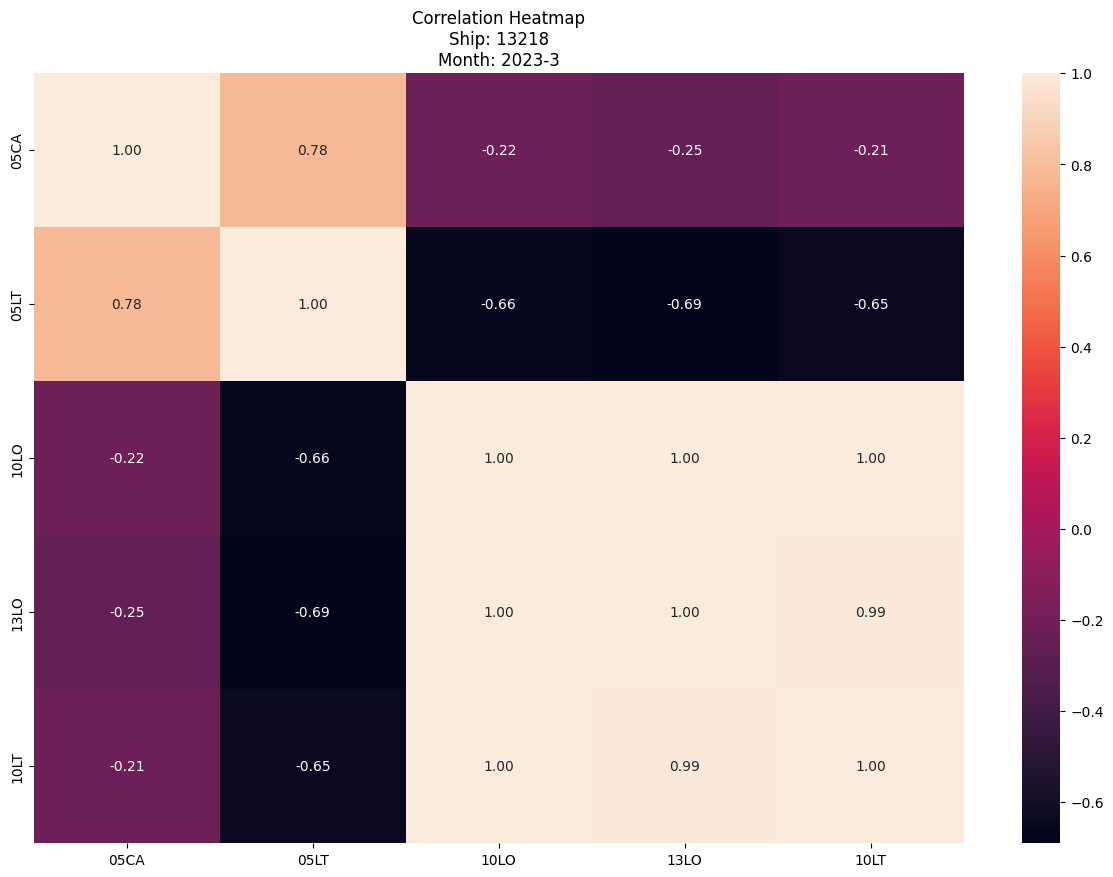

In [31]:
correlation_matrix = df.corr()

title = 'Correlation Heatmap'
ship = f'\nShip: {FILE["ship"]}'

if SIZE == 'month':
  date = f'\nMonth: {FILE["year"]}-{FILE["month"]}'
else:
  date = f'\nDate: {FILE["year"]}-{FILE["month"]}-{FILE["day"]}'

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title(title + ship + date)
plt.show()

## Analysing the correlation heat map for March on boat 13218

*   **Highly Correlated:**
  * 10LT and 13LO have a correlation of 0.99, indicating a very strong positive relationship.
  * 10LO and 10LT also have a correlation of 1.00, indicating a perfect positive relationship.
  * 10LO and 13LO similarly have a correlation of 1.00, indicating a perfect positive relationship.
  * 05LT and 05CA have a correlation of 0.78, which is quite strong.
* **Negatively Correlated:**
  * 05LT and 10LT have a correlation of -0.65, indicating a strong negative relationship.
  * 05LT and 10LO have a correlation of -0.66, indicating a strong negative relationship.
  * 13LO and 05LT have a correlation of -0.69, indicating a strong negative relationship.
* **Low or No Correlation:**
  * 05CA and 10SA have a correlation of 0.06, which suggests a very weak positive relationship.
  * 10SA and 14SA have a correlation of -0.03, which suggests virtually no linear relationship.
  * 05LT and 14SA have a correlation of -0.23, which is a weak negative relationship.

# LSTM Model Implementation

In [33]:
# Model version
VERSION = 'v1'

# Model architecture
ARCHITECTURE = 'LSTM'


# Scaler: Active scaler
SCALING_ALGORITHM = 'minmax'  # $mimax, $standard, robust, normalizer
SCALER_PATH       = '/content/drive/MyDrive/scalers/'
SCALER_NAME       = f'{TAG_NAME}-{SCALING_ALGORITHM}-Dataset[{SHORT}]'

# Model: Input and output attributes
X_ATTRIBUTES = x_attr
Y_ATTRIBUTES = y_attr

# Training: Early callback monitors
CALLBACK_LISTENERS = ['loss', 'val_loss']
CALLBACK_PATIENCE  = 5                   # [ 5, 10, 15, 20]

# Model: Compilation
USE_2_LSTM_LAYERS    = False
LSTM_LAYER_1_UNITS   = 64
LSTM_LAYER_2_UNITS   = 128
TEST_SIZE_PROPORTION = 0.2
DROPOUT              = 0.05
OPTIMIZER            = 'sgd'  # $rmsprop, adam, adamax, $sgd
LOSS_FUNCTION        = 'mse'

# Training: Epochs and batch size
EPOCHS     = 10                           # [15, 20, 25, 60]
BATCH_SIZE = 64

Epoch 1/10
32804/32804 [==============================] - 159s 5ms/step - loss: 0.0721 - val_loss: 0.0080
Epoch 2/10
32804/32804 [==============================] - 153s 5ms/step - loss: 0.0392 - val_loss: 0.0079
Epoch 3/10
32804/32804 [==============================] - 152s 5ms/step - loss: 0.0362 - val_loss: 0.0090
Epoch 4/10
32804/32804 [==============================] - 153s 5ms/step - loss: 0.0341 - val_loss: 0.0140
Epoch 5/10
32804/32804 [==============================] - 152s 5ms/step - loss: 0.0325 - val_loss: 0.0159
Epoch 6/10
32804/32804 [==============================] - 151s 5ms/step - loss: 0.0313 - val_loss: 0.0198
Epoch 7/10
32804/32804 [==============================] - 151s 5ms/step - loss: 0.0305 - val_loss: 0.0250




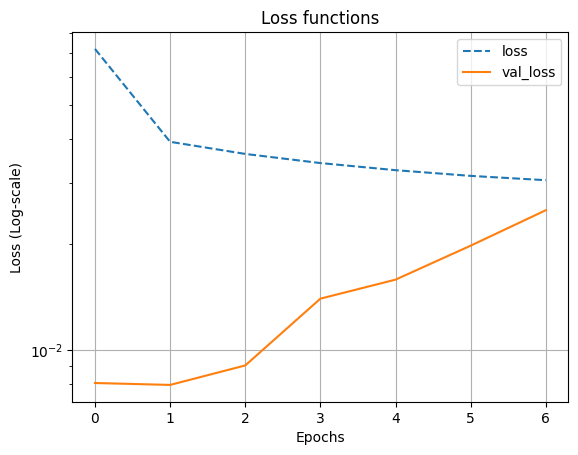

In [34]:
Y_ATTRIBUTES = y_attr

# Setting desired input and output attributes
num_attributes_x = len(X_ATTRIBUTES)
num_attributes_y = len(Y_ATTRIBUTES)
timesteps = 1

dfx = df[X_ATTRIBUTES]
dfy = df[Y_ATTRIBUTES]


# Scaling algorithms
SCALERS = {
    'standard':     StandardScaler().fit(dfx),
    'minmax':       MinMaxScaler(feature_range=(0, 1)).fit(dfx),
    'robust':       RobustScaler().fit(dfx),
    'normalizer':   Normalizer().fit(dfx)
}

# Specifying which scaler to use
scaler = SCALERS[ SCALING_ALGORITHM ]        # NB: Scaler must be the same as the one used for training
joblib.dump(scaler, f'{SCALER_PATH}{SCALER_NAME}.joblib') # This code was generated by ChatGPT (OpenAI)
dfx = pd.DataFrame(scaler.transform(dfx))


X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=TEST_SIZE_PROPORTION, shuffle=False)

X_train = X_train.to_numpy().reshape(X_train.shape[0], timesteps, num_attributes_x)
y_train = y_train.to_numpy().reshape(y_train.shape[0], timesteps, num_attributes_y)

X_test  =  X_test.to_numpy().reshape(X_test.shape[0],  timesteps, num_attributes_x)
y_test  =  y_test.to_numpy().reshape(y_test.shape[0],  timesteps, num_attributes_y)


# Define LSTM model
model = Sequential()
model.add( Bidirectional(LSTM(LSTM_LAYER_1_UNITS, input_shape=(timesteps, num_attributes_x), return_sequences=True)) )
if USE_2_LSTM_LAYERS:
  model.add( Bidirectional(LSTM(LSTM_LAYER_2_UNITS, return_sequences=True)) )
model.add( Dropout(DROPOUT) )
model.add( Dense(num_attributes_y) )


# Compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION)


# Adding early stopping listeners for validation metrics
callbacks = []
for listener in CALLBACK_LISTENERS:
  callbacks.append( EarlyStopping(monitor=listener, patience=CALLBACK_PATIENCE, restore_best_weights=True) )


# Training the model
trained_model = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  validation_data=(X_test, y_test), callbacks=callbacks)


# Plotting the loss as a function of epochs
print('\n')
plt.plot(trained_model.history['loss'],     label='loss', linestyle='dashed')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log-scale)')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [35]:
# Perform predictions
predictions = model.predict(X_test)

# Split the transposed array into 8 separate arrays
print(f'\nDimensions of the array before:\t {predictions.shape}')

# Predictions are on the format (num_observations x timesteps x num_attributes_y)
# We need to convert it to the format (num_attributes_y x num_observations)
# This code was generated by ChatGPT (OpenAI)
predictions = np.transpose(predictions, (2, 1, 0))
predictions = np.array([predictions[i].flatten() for i in range(predictions.shape[0])])

print(f'Dimensions of the array after:\t {predictions.shape}')
print(f'\nPredictions:\n{predictions}')

16402/16402 [==============================] - 34s 2ms/step

Dimensions of the array before:	 (524851, 1, 1)
Dimensions of the array after:	 (1, 524851)

Predictions:
[[5.1105003  5.1105003  5.1084146  ... 0.56950665 0.56950665 0.56950665]]


In [36]:
# Preparing the actual values of 01EX, 02EX, ..., 08EX
y_test = np.transpose(y_test, (2, 1, 0))
y_test = np.array([y_test[i].flatten() for i in range(y_test.shape[0])])

print('\tActual\t\tPrediction\tDifference')
print(f'\t{42 * "-"}')

# Printing mean of actual, prediction, and the difference between them
for i in range(num_attributes_y):
  actual  = round(float(y_test[i].mean()), ROUND)
  predict = round(float(predictions[i].mean()), ROUND)
  diff    = round(abs(actual - predict), ROUND)

  print(f'{y_attr[i]}:\t{actual}\t\t{predict}\t\t{diff}')

	Actual		Prediction	Difference
	------------------------------------------
10LT:	4.405		4.384		0.021


# Observations




Mean Squared Error: 0.008
Root Mean Squared Error: 0.089
Mean Absolute Error: 0.048
R-squared: 0.997 




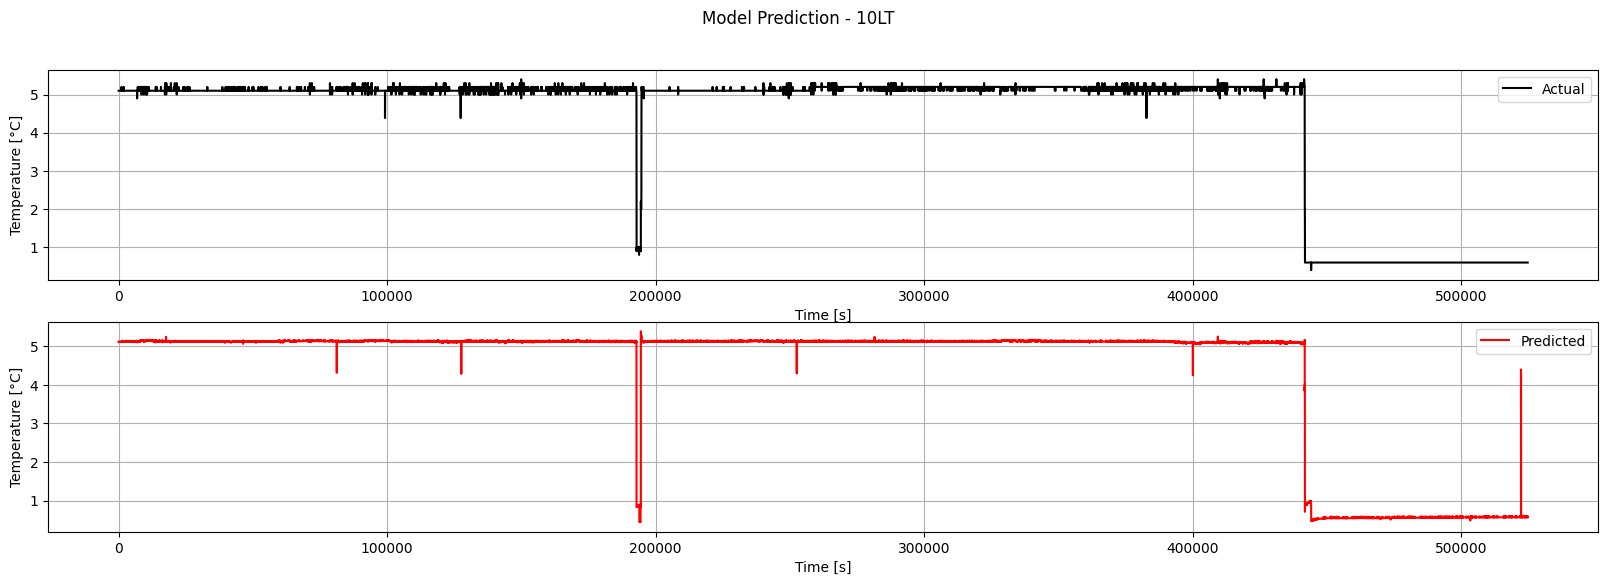

In [37]:
# Looping through each array of attribute predictions
for i in range(num_attributes_y):
  print('\n')

  feature = y_attr[i]

  fig, ax = plt.subplots(2, 1, figsize=(20, 6))
  fig.suptitle(f'Model Prediction - {feature}')

  # Converting attribute predictions and actual values to numpy arrays
  predict = predictions[y_attr.index(feature)]
  actual  = y_test[i]

  # Plotting line graphs for prediction vs. actual
  ax[0].plot(actual,  label='Actual',    color='black', linestyle='-')
  ax[1].plot(predict, label='Predicted', color='red',   linestyle='-' )
  ax[0].legend(['Actual'])
  ax[1].legend(['Predicted'])
  ax[0].grid()
  ax[1].grid()

  ax[0].set_xlabel('Time [s]')
  ax[1].set_xlabel('Time [s]')
  ax[0].set_ylabel('Temperature [°C]')
  ax[1].set_ylabel('Temperature [°C]')

  # Calculating quantitative accuracy measures
  mse  = round(mean_squared_error(actual, predict), ROUND)
  mae  = round(mean_absolute_error(actual, predict), ROUND)
  r2   = round(r2_score(actual, predict), ROUND)
  rmse = round(np.sqrt(mse), ROUND)

  # Printing quantitative accuracy measures
  print(f'\nMean Squared Error: {mse}')
  print(f'Root Mean Squared Error: {rmse}')
  print(f'Mean Absolute Error: {mae}')
  print(f'R-squared: {r2} \n\n')

plt.show()

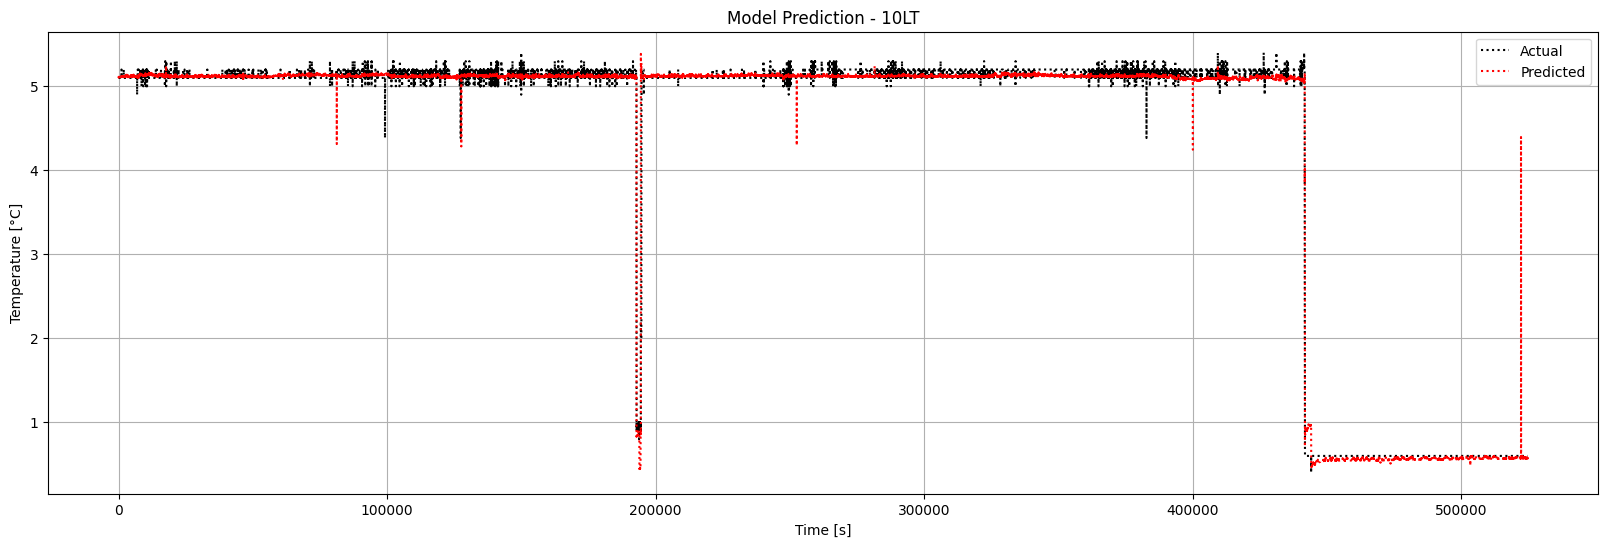


Mean Squared Error: 0.008
Root Mean Squared Error: 0.089
Mean Absolute Error: 0.048
R-squared: 0.997 




In [38]:
plt.figure(figsize=(20,6))

# Looping through each array of attribute predictions
for i in range(num_attributes_y):

  feature = y_attr[i]

  # Converting attribute predictions and actual values to numpy arrays
  predict = predictions[y_attr.index(feature)]
  actual  = y_test[i]

  # Plotting line graphs for prediction vs. actual
  plt.plot(actual,  label='Actual',    color='black', linestyle=':')
  plt.plot(predict, label='Predicted', color='red',   linestyle=':' )

  plt.xlabel('Time [s]')
  plt.ylabel('Temperature [°C]')
  plt.title(f'Model Prediction - {feature}')

  plt.legend()
  plt.grid()
  plt.show()

  # Calculating quantitative accuracy measures
  mse  = round(mean_squared_error(actual, predict), ROUND)
  mae  = round(mean_absolute_error(actual, predict), ROUND)
  r2   = round(r2_score(actual, predict), ROUND)
  rmse = round(np.sqrt(mse), ROUND)

  # Printing quantitative accuracy measures
  print(f'\nMean Squared Error: {mse}')
  print(f'Root Mean Squared Error: {rmse}')
  print(f'Mean Absolute Error: {mae}')
  print(f'R-squared: {r2} \n\n')

In [39]:
trained_model.model.save(f'{DIR}{DATE}-{VERSION}-{ARCHITECTURE}-{TAG_NAME}.h5')